# Imports

In [1]:
import re

from random import choices, randint
from string import ascii_lowercase
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Instructions

In summary: We have two sequences A & B. We wish to produce a Boolean sequence, A', where each element says whether or not the corresponding element in A has a subsequence which occurs in B.

More formally, we have two sequences of sequences of bytes, A & B, for each of A & B no sequence of bytes occurs in the sequence more than once. E.g. (using pseudo code), A or B might be < < 1, 2, 3 >, < 3, 2, 1 > >, but neither would be < < 1, 2, 3 >, <2, 3>, < 1, 2, 3 > > as this has an element that occurs more than once; namely < 1, 2, 3 >.

We wish to produce a Boolean sequence, A', such that for any x in A' with index i, x is 'true' if and only if there exists a y in B and a sequence z where z is a consecutive subsequence of the ith element of A and z == y. By consecutive subsequence we mean z is as a result of taking a range of elements, just like taking a substring of a string.

For example:
A = < < 1, 2, 3 >, < 2, 3 >, < 1, 44, 3 >, < 100, 6, 33, > , < 7 > >
B = < < 44, 1 >, < 100, 33 >, < 2, 3 >, < 7, 28 > >
then A' would be < true, true, false, false, false >

You may assume the sequences of bytes in both A and B are quite short, say around length 20 or less.  Please write three methods such that given parameters A and B, returns A', where

1. Both A & B are trivially small, and you need not worry about the frequency with which your method will be called in an application - it won't be that often.
2. For one method it is assumed A is really big (it certainly cannot fit in memory or on the hard drives of a single computer), B is trivially small; length a couple of 100 say.
3. As above but switch A and B, so B is really big and A is small.
4. Both A and B are large.

You don't have to assume A & B are of a specific type, it's up to you to determine what is the natural type of these things.  You may choose streams, iterators, lists, rdds, arrays ... etc, whatever you think best fits.

# Generate test data

Choices:
 - I am choosing to represent byte sequences with strings
 - Justification: Any byte can be mapped to a character and vice-versa (for a 256 character set)
 - This also allows me to use optimised regex code if necessary
 - I am choosing to use lowercase letters for simplicity of debugging, but this this could be extended to larger (e.g. 256 character) sets

In [2]:
def generate_list_of_strings(min_len, max_len, n, index=False):
    """Generate test data"""
    strings = [''.join(choices(ascii_lowercase, k=randint(min_len, max_len))) for i in range(n)]
    return list(zip(strings, range(n))) if index else strings

# Function definitions

These two functions allow basic searching of items in A for substrings in B. Numpy is used for convenience but this is fairly bare-metal code. It performs surprisingly well.

In [3]:
def get_all_substrings(string, min_len=1, return_lengths=True):
    """Get all substrings above a minimum length for a given string"""
    length = len(string)
    for i in range(length):
        for j in range(i + min_len, length + 1):
            yield (string[i:j], j - i) if return_lengths else string[i:j]

In [4]:
def find_exact_match(A, B):
    """Finds all substrings of A and exact matches against B"""
    B_sorted = np.array(sorted(B, key=len))
    B_lengths = np.array([len(b) for b in B_sorted])
    
    min_len = B_lengths.min()
    
    start_idx = {}
    stop_idx = {}
    for length in set(B_lengths):
        start_idx[length] = np.searchsorted(B_lengths, length, side='left')
        stop_idx[length] = np.searchsorted(B_lengths, length, side='right')
    
    return[any([substr in B_sorted[start_idx.get(str_len, 0):stop_idx.get(str_len, 0)]
                for substr, str_len in get_all_substrings(a, min_len)])
           for a in A]

These functions use the python regex library. List comp and map are very comparable in performance terms - list comp preferred for readbility.

In [5]:
def regex_find_list_comp(A, B):
    compiled_regex = re.compile('|'.join(B))
    return [bool(compiled_regex.search(a)) for a in A]

In [6]:
def regex_find_map(A, B):
    compiled_regex = re.compile('|'.join(B))
    return map(lambda a: bool(compiled_regex.search(a)), A)

Deduping might be important...

In [7]:
def dedupe_substrings(B, finder=regex_find_list_comp):
    B_sorted = np.array(sorted(B, key=len))
    B_lengths = np.array([len(b) for b in B_sorted])
    
    for length in set(B_lengths):
        start_idx = np.searchsorted(B_lengths, length, side='left')
        stop_idx = np.searchsorted(B_lengths, length, side='right')
        dupes = finder(B_sorted[stop_idx:], B_sorted[start_idx:stop_idx])
        mask = np.concatenate((np.ones(stop_idx), np.logical_not(dupes))).astype(bool)
        B_sorted = B_sorted[mask]
        B_lengths = B_lengths[mask]
    
    return B_sorted

These functions add logic to avoid searching for impossible matches (substrings of A that are longer than items in B)

In [8]:
def quick_find(A, B):
    B_sorted = np.array(sorted(B, key=len))
    B_lengths = np.array([len(b) for b in B_sorted])
    regex_dict = {}
    for length in set(B_lengths):
        stop_idx = np.searchsorted(B_lengths, length, side='right')
        regex_dict[length] = re.compile('|'.join(B_sorted[:stop_idx]))
    return [bool(regex_dict[len(a)].search(a)) for a in A]

In [9]:
def quick_find_deduped(A, B):
    B_deduped = dedupe_substrings(B)
    B_lengths = np.array([len(b) for b in B_deduped])
    regex_dict = {}
    for length in set(B_lengths):
        stop_idx = np.searchsorted(B_lengths, length, side='right')
        regex_dict[length] = re.compile('|'.join(B_deduped[:stop_idx]))
    return [bool(regex_dict[len(a)].search(a)) for a in A]

# Algorithmic performance (single core) per method 

In [44]:
results = {}
 
for n in [500, 1000, 2000, 4000, 8000, 12000, 18000, 24000, 30000]:
    
    test_A = generate_list_of_strings(3, 20, n, index=False)
    test_B = generate_list_of_strings(3, 20, n, index=False)
    
    for method in [find_exact_match,
                   regex_find_list_comp,
                   regex_find_map,
                   quick_find,
                   quick_find_deduped]:
        
        results[(n, method.__name__)] = {}
        start_time = time()
        results[(n, method.__name__)]['checksum'] = sum(list(method(test_A, test_B)))
        results[(n, method.__name__)]['time'] = time() - start_time

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'level_0': 'size', 'level_1': 'method'})

In [80]:
results_df

,size,method,checksum,time
0,500,find_exact_match,7.0,0.199082
1,500,regex_find_list_comp,7.0,0.029581
2,500,regex_find_map,7.0,0.013714
3,500,quick_find,7.0,0.132187
4,500,quick_find_deduped,7.0,0.238521
5,1000,find_exact_match,28.0,0.396278
6,1000,regex_find_list_comp,28.0,0.087707
7,1000,regex_find_map,28.0,0.054979
8,1000,quick_find,28.0,0.404198
9,1000,quick_find_deduped,28.0,0.400750


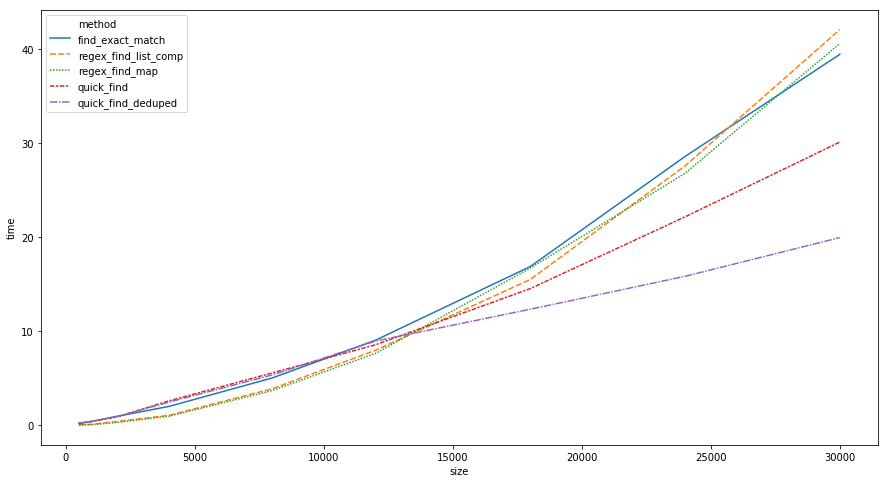

In [46]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(data=results_df, x='size', y='time', hue='method', style='method', ax=ax);

# Case 1: Small A, small B

No need to parallelize: Use `find_exact_match()` or any other finder method above.

# SparkContext settings

The below code is running on a low-powered MacBook pro with 4 cores, running PySpark in jupyter as described [here](https://towardsdatascience.com/how-to-use-pyspark-on-your-computer-9c7180075617). However code should translate to a cluster or more powerful machine.

In [79]:
sc.defaultParallelism

4

# Case 2: Big A, small B

Strategy:
 - Dedupe and broadcast (or just use local variable) B
 - Parallelize A
 - Generate all substrings for A in partition
 - Exact match search against B in parallel
 - Collect results

In [53]:
A = generate_list_of_strings(min_len=3, max_len=20, n=1000000, index=True)
B = generate_list_of_strings(min_len=3, max_len=20, n=200)

In [54]:
%%time
sum(quick_find_deduped([a[0] for a in A], B))

CPU times: user 6.01 s, sys: 42.1 ms, total: 6.05 s
Wall time: 6.16 s


6477

In [55]:
B_deduped = list(dedupe_substrings(B)) # numpy arrays seem much slower to process than lists
min_len_B = min([len(b) for b in B_deduped])

In [56]:
rdd_A = sc.parallelize(A)

In [57]:
rdd_A_substring_lists = rdd_A.map(lambda x: (list(get_all_substrings(x[0], min_len_B, return_lengths=False)), x[1]))

In [62]:
%%time
answer = rdd_A_substring_lists.map(lambda x: bool(set(x[0]).intersection(B_deduped))).collect()

CPU times: user 49.9 ms, sys: 16.3 ms, total: 66.2 ms
Wall time: 13.4 s


In [64]:
sum(answer)

6477

# Case 3: Small A, big B

Strategy:
 - Paralellize B (no deduping)
 - Generate all substrings of A and parallelize
 - Exact match search in parallel
 - Collect results

In [59]:
A = generate_list_of_strings(min_len=4, max_len=20, n=200, index=True)
B = generate_list_of_strings(min_len=4, max_len=20, n=1000000)

In [60]:
A_strings_only = list(zip(*A))[0]

In [65]:
%%time
sum(find_exact_match(A_strings_only, B))

CPU times: user 10.7 s, sys: 107 ms, total: 10.8 s
Wall time: 10.9 s


177

In [66]:
A_substrings = [(substr, idx) for (a, idx) in A for substr in list(get_all_substrings(a, return_lengths=False))]
len(A_substrings)

19231

In [67]:
rdd_A = sc.parallelize(A_substrings)
rdd_B = sc.parallelize(B).keyBy(lambda x: x)

In [68]:
test = rdd_A.join(rdd_B).values().keys().distinct()

In [69]:
%%time
len(test.collect())

CPU times: user 4.78 ms, sys: 2.53 ms, total: 7.31 ms
Wall time: 7.34 s


177

# Case 4: Big A, big B

Strategy:
 - Parallelize A
 - Generate all substrings and re-parallelize
 - Parallelize B
 - Exact match search in parallel
 - Collect results (assuming list of booleans will fit in local memory) 

In [81]:
A = generate_list_of_strings(min_len=4, max_len=20, n=150000, index=True)
B = generate_list_of_strings(min_len=4, max_len=20, n=150000)

In [71]:
A_strings_only = list(zip(*A))[0]

In [73]:
%%time
sum(find_exact_match(A_strings_only, B))

CPU times: user 1min 29s, sys: 891 ms, total: 1min 30s
Wall time: 1min 30s


2784

In [82]:
rdd_A = sc.parallelize(A)
rdd_B = sc.parallelize(B).keyBy(lambda x: x)

In [83]:
min_len_B = rdd_B.map(lambda x: len(x[0])).min()
min_len_B

4

In [84]:
rdd_A_substrings = (
    rdd_A.flatMap(lambda x: [
        (substr, x[1]) for substr in list(get_all_substrings(x[0], min_len_B, return_lengths=False))
    ])
)

In [85]:
%%time
test = rdd_A_substrings.join(rdd_B).values().keys().distinct().collect()

CPU times: user 44.9 ms, sys: 55.9 ms, total: 101 ms
Wall time: 2min 5s


In [86]:
len(test)

24149

# Archive

In [38]:
def dedupe_substrings_old(B):
    original_length = len(B)
    B_sorted = sorted(sorted(set(B)), key=len)
    B_lengths = [len(b) for b in B_sorted]
    for b_short in B_sorted:
        if len(b_short) < B_lengths[-1]:
            start_search_index = np.searchsorted(B_lengths, len(b_short), side='right')
            match_indices = []
            for idx, b_long in enumerate(B_sorted[start_search_index:]):
                if re.search(b_short, b_long):
                    match_indices.append(start_search_index + idx)
            for match_idx in match_indices[::-1]:
                del B_sorted[match_idx]
                del B_lengths[match_idx]
    final_length = len(B_sorted)
    print(f'Removed {original_length - final_length} out of {original_length} items')
    return B_sorted, B_lengths

In [39]:
def find_exact_deduped(A, B):
    B_deduped = dedupe_substrings(B)
    B_lengths = np.array([len(b) for b in B_deduped])
    min_len = B_lengths.min()
    start_idx = {}
    stop_idx = {}
    for length in set(B_lengths):
        start_idx[length] = np.searchsorted(B_lengths, length, side='left')
        stop_idx[length] = np.searchsorted(B_lengths, length, side='right')
    return[any([substr in B_deduped[start_idx.get(str_len, 0):stop_idx.get(str_len, 0)]
                for substr, str_len in get_all_substrings(a, min_len)]) 
           for a in A]

In [40]:
def naive_regex_finder(A, B):
    return [max([bool(re.search(b[j], a[i])) for j in range(len(b))]) for i in range(len(a))]

In [41]:
def naive_finder2(A, B):
    B_deduped, B_lengths = dedupe_substrings_old(B)
    matches = []
    for a in A:
        matches.append(False)
        stop_search_index = np.searchsorted(B_lengths, len(a), side='right')
        for b in B_deduped[:stop_search_index]:
            if re.search(b, a):
                matches[-1] = True
                break
    return matches

In [42]:
def naive_finder3(A, B):
    B_deduped, B_lengths = dedupe_substrings_old(B)
    matches = []
    stop_indices = {
        length: np.searchsorted(B_lengths, length, side='right')
        for length in range(B_lengths[0], B_lengths[-1] + 1)
    }
    for a in A:
        matches.append(False)
        for b in B_deduped[:stop_indices[len(a)]]:
            if re.search(b, a):
                matches[-1] = True
                break
    return matches